In [14]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

import spacy

import matplotlib.pyplot as pyplot
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [4]:
df=pd.read_csv('got_scripts_breakdown.csv', sep=';')
df.head()

,Column1,Season,Episode,Sentence,Name,N_serie,N_Season,Emision Date
0,1,Season 1,winter is coming,What d’you expect? They’re savages One lot ste...,waymar royce,1,1,17/04/2011
1,2,Season 1,winter is coming,I’ve never seen wildlings do a thing like this...,will,1,1,17/04/2011
2,3,Season 1,winter is coming,How close did you get?,waymar royce,1,1,17/04/2011
3,4,Season 1,winter is coming,Close as any man would,will,1,1,17/04/2011
4,5,Season 1,winter is coming,We should head back to the wall,gared,1,1,17/04/2011


In [5]:
# Convert to list
data = df.Sentence.values.tolist()

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['what', 'you', 'expect', 'they', 're', 'savages', 'one', 'lot', 'steals', 'goat', 'from', 'another', 'lot', 'and', 'before', 'you', 'know', 'it', 'they', 're', 'ripping', 'each', 'other', 'to', 'pieces']]


In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['what', 'you', 'expect', 'they', 're', 'savages', 'one', 'lot', 'steals', 'goat', 'from', 'another', 'lot', 'and', 'before', 'you', 'know', 'it', 'they', 're', 'ripping', 'each_other', 'to', 'pieces']


In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['expect', 'savage', 'lot', 'steal', 'goat', 'lot', 'know', 'rip', 'piece']]


In [14]:
model1.wv.most_similar(positive=["dragon"])

[('breaker', 0.9681887030601501),
 ('grass', 0.9524262547492981),
 ('ala', 0.9518758058547974),
 ('valyria', 0.9513086676597595),
 ('rhoynar', 0.9467923641204834),
 ('daenerys_stormborn', 0.9460152983665466),
 ('dynasty', 0.9458006620407104),
 ('chain', 0.9452958703041077),
 ('unburnt', 0.9430876970291138),
 ('khaleesi', 0.9423307776451111)]

In [9]:
# train model
model2 = gensim.models.Word2Vec(
        data_lemmatized,
        window=10,
        min_count=2,
        workers=10,
        iter=10,
        size=300)
#print(model2)
words2 = list(model2.wv.vocab)
#print(words2[:100])
#print(model2['winter'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


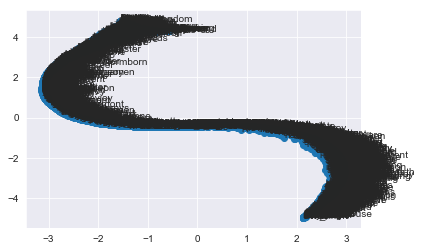

In [15]:
data_subset = model2[model2.wv.vocab]
# pca = PCA(n_components=50)
# pca_result_50 = pca.fit_transform(data_subset)

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=250)
tsne_pca_results = tsne.fit_transform(data_subset)
# create a scatter plot of the projection


pyplot.scatter(tsne_pca_results[:, 0], tsne_pca_results[:, 1])
words2 = list(model2.wv.vocab)
for i, word in enumerate(words2):
    pyplot.annotate(word, xy=(tsne_pca_results[i, 0], tsne_pca_results[i, 1]))
pyplot.show()

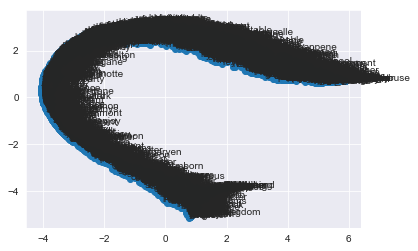

In [17]:
tsne_p_20 = TSNE(n_components=2, verbose=0, perplexity=20, n_iter=250)
tsne_pca_results_p_20 = tsne_p_20.fit_transform(data_subset)
# create a scatter plot of the projection


pyplot.scatter(tsne_pca_results_p_20[:, 0], tsne_pca_results_p_20[:, 1])
words2 = list(model2.wv.vocab)
for i, word in enumerate(words2):
    pyplot.annotate(word, xy=(tsne_pca_results_p_20[i, 0], tsne_pca_results_p_20[i, 1]))
pyplot.show()

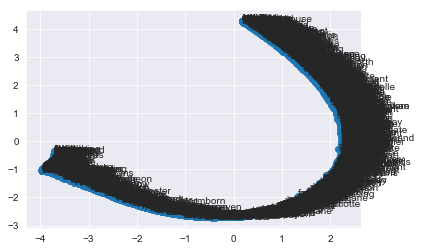

In [18]:
tsne_p_60 = TSNE(n_components=2, verbose=0, perplexity=60, n_iter=250)
tsne_pca_results_p_60 = tsne_p_60.fit_transform(data_subset)
# create a scatter plot of the projection


pyplot.scatter(tsne_pca_results_p_60[:, 0], tsne_pca_results_p_60[:, 1])
words2 = list(model2.wv.vocab)
for i, word in enumerate(words2):
    pyplot.annotate(word, xy=(tsne_pca_results_p_60[i, 0], tsne_pca_results_p_60[i, 1]))
pyplot.show()

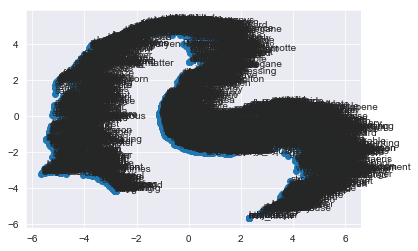

In [19]:
tsne_p_5 = TSNE(n_components=2, verbose=0, perplexity=5, n_iter=250)
tsne_pca_results_p_5 = tsne_p_5.fit_transform(data_subset)
# create a scatter plot of the projection


pyplot.scatter(tsne_pca_results_p_5[:, 0], tsne_pca_results_p_5[:, 1])
words2 = list(model2.wv.vocab)
for i, word in enumerate(words2):
    pyplot.annotate(word, xy=(tsne_pca_results_p_5[i, 0], tsne_pca_results_p_5[i, 1]))
pyplot.show()

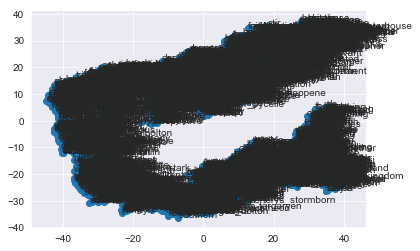

In [25]:
tsne_i_500 = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=500)
tsne_pca_results_i_500 = tsne_i_500.fit_transform(data_subset)
# create a scatter plot of the projection


pyplot.scatter(tsne_pca_results_i_500[:, 0], tsne_pca_results_i_500[:, 1])
words2 = list(model2.wv.vocab)
for i, word in enumerate(words2):
    pyplot.annotate(word, xy=(tsne_pca_results_i_500[i, 0], tsne_pca_results_i_500[i, 1]))
pyplot.show()

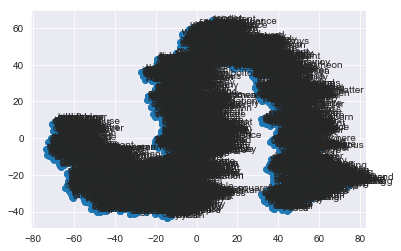

In [24]:
tsne_i_1000 = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=1000)
tsne_pca_results_i_1000 = tsne_i_1000.fit_transform(data_subset)
# create a scatter plot of the projection


pyplot.scatter(tsne_pca_results_i_1000[:, 0], tsne_pca_results_i_1000[:, 1])
words2 = list(model2.wv.vocab)
for i, word in enumerate(words2):
    pyplot.annotate(word, xy=(tsne_pca_results_i_1000[i, 0], tsne_pca_results_i_1000[i, 1]))
pyplot.show()

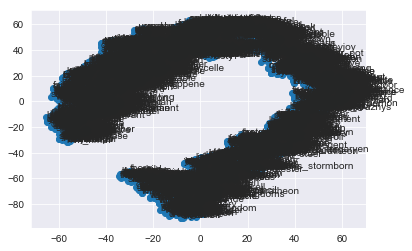

In [26]:
tsne_i_2000 = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=2000)
tsne_pca_results_i_2000 = tsne_i_2000.fit_transform(data_subset)
# create a scatter plot of the projection


pyplot.scatter(tsne_pca_results_i_2000[:, 0], tsne_pca_results_i_2000[:, 1])
words2 = list(model2.wv.vocab)
for i, word in enumerate(words2):
    pyplot.annotate(word, xy=(tsne_pca_results_i_2000[i, 0], tsne_pca_results_i_2000[i, 1]))
pyplot.show()

In [28]:
# train model
model1 = gensim.models.Word2Vec(
        data_lemmatized,
        window=10,
        min_count=2,
        workers=10,
        iter=10,
        size=200)
#print(model2)
words1 = list(model1.wv.vocab)
#print(words2[:100])
#print(model2['winter'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


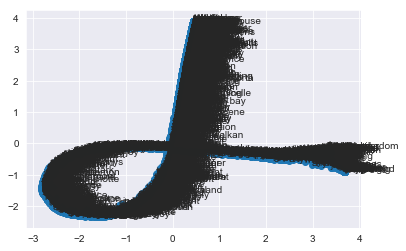

In [34]:
data_subset1 = model1[model1.wv.vocab]

tsne1 = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=250)
tsne_pca_results1 = tsne1.fit_transform(data_subset1)
# create a scatter plot of the projection


pyplot.scatter(tsne_pca_results1[:, 0], tsne_pca_results1[:, 1])
words1 = list(model1.wv.vocab)
for i, word in enumerate(words2):
    pyplot.annotate(word, xy=(tsne_pca_results1[i, 0], tsne_pca_results1[i, 1]))
pyplot.show()

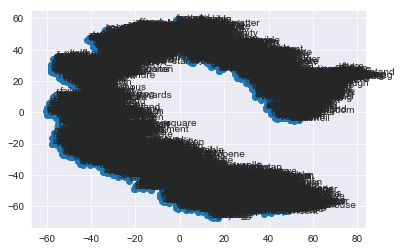

In [35]:
tsne1_i_2000 = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=2000)
tsne_pca_results1_i_2000 = tsne1_i_2000.fit_transform(data_subset1)
# create a scatter plot of the projection


pyplot.scatter(tsne_pca_results1_i_2000[:, 0], tsne_pca_results1_i_2000[:, 1])
words1 = list(model1.wv.vocab)
for i, word in enumerate(words2):
    pyplot.annotate(word, xy=(tsne_pca_results1_i_2000[i, 0], tsne_pca_results1_i_2000[i, 1]))
pyplot.show()

In [33]:
# train model
model3 = gensim.models.Word2Vec(
        data_lemmatized,
        window=5,
        min_count=2,
        workers=10,
        iter=10,
        size=300)
#print(model2)

data_subset3 = model3[model3.wv.vocab]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


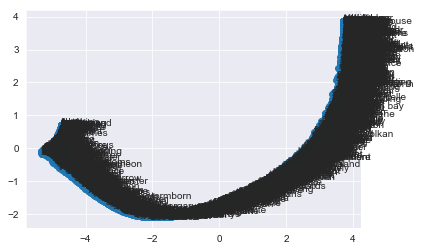

In [36]:
data_subset3 = model3[model3.wv.vocab]

tsne3 = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=250)
tsne_pca_results3 = tsne3.fit_transform(data_subset1)
# create a scatter plot of the projection


pyplot.scatter(tsne_pca_results3[:, 0], tsne_pca_results3[:, 1])
words3 = list(model3.wv.vocab)
for i, word in enumerate(words2):
    pyplot.annotate(word, xy=(tsne_pca_results3[i, 0], tsne_pca_results3[i, 1]))
pyplot.show()